In [0]:
silver_df = spark.read.option("header", True).csv(
    "abfss://output@mahibasupplychainadls.dfs.core.windows.net/silver/silver_merged"
)

In [0]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

GOLD_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features/"
FINAL_OUTPUT = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features_final/"

date_col = "Date"
target_col = "Econ_Index_x"

print(" Loading GOLD feature files...")

df = (
    spark.read
        .format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load(GOLD_PATH + "*.csv")
)

print("Loaded shape =", (df.count(), len(df.columns)))
df.printSchema()

print("🔧 Formatting date column...")

df = df.withColumn(date_col, F.to_date(F.col(date_col)))

print(" Fixing target column type...")

df = df.withColumn(target_col, F.col(target_col).cast("double"))

print(" Removing duplicates...")

df = df.dropDuplicates()

print(" Sorting by date...")

df = df.orderBy(date_col)

print(" Sample formatted GOLD data:")
df.show(10)

print("Writing formatted GOLD file...")

(
    df.coalesce(1)
      .write
      .format("csv")
      .mode("overwrite")
      .option("header", True)
      .save(FINAL_OUTPUT)
)

print(" GOLD formatted file saved to:", FINAL_OUTPUT)


 Loading GOLD feature files...
Loaded shape = (10962, 34)
root
 |-- Daily_Usage_Units_x: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Downtime_Min_x: integer (nullable = true)
 |-- Econ_Index_x: integer (nullable = true)
 |-- Peak_Usage_Units_x: integer (nullable = true)
 |-- Region_x: string (nullable = true)
 |-- Season_x: string (nullable = true)
 |-- Service_x: string (nullable = true)
 |-- Storage_TB_x: integer (nullable = true)
 |-- VM_Count_x: integer (nullable = true)
 |-- Cloud_Demand_Index: string (nullable = true)
 |-- GDP_Growth: string (nullable = true)
 |-- Inflation: string (nullable = true)
 |-- Competitor_Price_Index: string (nullable = true)
 |-- Region_y: string (nullable = true)
 |-- Service_y: string (nullable = true)
 |-- Daily_Usage_Units_y: string (nullable = true)
 |-- Peak_Usage_Units_y: string (nullable = true)
 |-- VM_Count_y: string (nullable = true)
 |-- Storage_TB_y: string (nullable = true)
 |-- Season_y: string (nullable = true)
 |

In [0]:
print("Unique values in Econ_Index_x:")
print(gold["Econ_Index_x"].unique()[:50])

print("\nNull count:")
print(gold["Econ_Index_x"].isna().sum())

print("\nDtype:")
print(gold["Econ_Index_x"].dtype)

print("\nHead:")
print(gold[["Date","Econ_Index_x"]].head())


Unique values in Econ_Index_x:
[ 82  83  87 108  92 104  96  85  81  88 107 109  86  93 103  97 100  80
  90 102  95 106 105  99  89  94  98 101  91  84]

Null count:
0

Dtype:
int64

Head:
                     Date  Econ_Index_x
0    -9223372036854775808            82
7303 -9223372036854775808            83
7304 -9223372036854775808            87
7305 -9223372036854775808           108
7306 -9223372036854775808            92


Loaded GOLD shape = (10962, 34)
Gold Layer → date_col = Date
Gold Layer → target_col = Econ_Index_x
Gold CSV written to: abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features


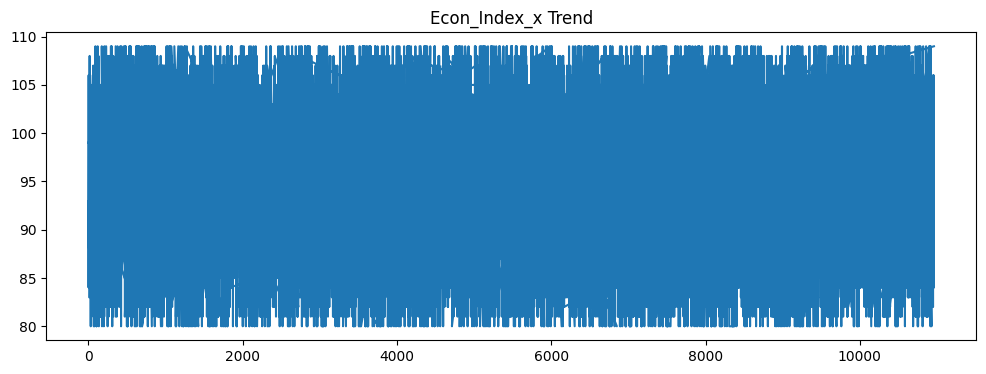

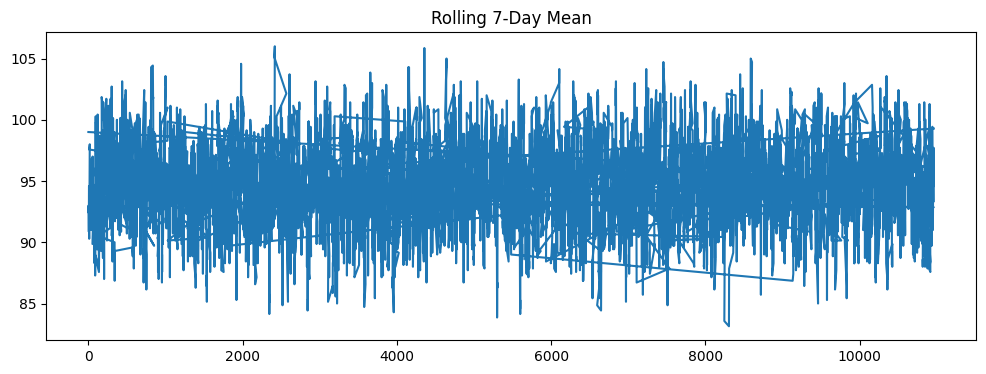

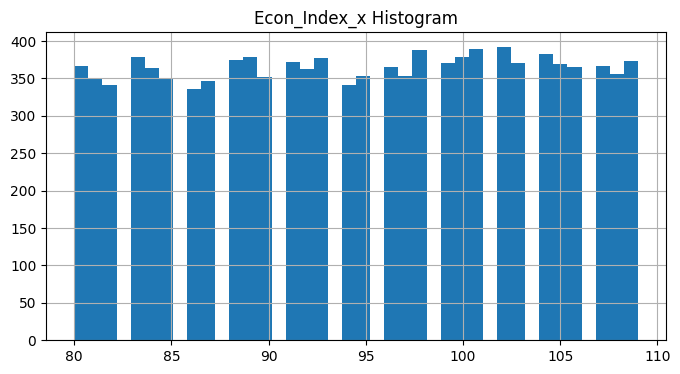

Gold Layer Completed.


In [0]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

SILVER_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/silver/silver_merged/"
GOLD_PATH   = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/"

# Load GOLD layer
gold_spark_df = spark.read.option("header", True).csv(GOLD_PATH + "gold_features/")
gold = gold_spark_df.toPandas()
print("Loaded GOLD shape =", gold.shape)

# Detect Date column
date_col = None
for c in gold.columns:
    if "date" in c.lower():
        date_col = c
        gold[c] = pd.to_datetime(gold[c], errors="coerce") if gold[c].dtype != 'datetime64[ns]' else gold[c]
        break

print("Gold Layer → date_col =", date_col)

# Detect Target column
target_candidates = [c for c in gold.columns 
                     if any(x in c.lower() 
                            for x in ["demand","sales","qty","quantity","index","target"])]
target_col = target_candidates[0] if target_candidates else None
print("Gold Layer → target_col =", target_col)

# Convert all numeric-looking columns to numeric
for c in gold.columns:
    gold[c] = pd.to_numeric(gold[c], errors="ignore")

# Convert "UNKNOWN" → NaN then fill numeric median, categorical with "UNKNOWN"
for c in gold.columns:
    if gold[c].dtype == object:
        gold[c] = gold[c].replace("UNKNOWN", np.nan)

for c in gold.select_dtypes(include=[np.number]).columns:
    if gold[c].isna().all():
        # Column has all NaN → fill with 0
        gold[c] = gold[c].fillna(0)
    else:
        # Normal numeric columns → fill median
        gold[c] = gold[c].fillna(gold[c].median())


# Fill non-numeric columns
for c in gold.select_dtypes(include=["object","category"]).columns:
    gold[c] = gold[c].fillna("UNKNOWN")

# Feature engineering
if date_col:
    gold = gold.sort_values(date_col); gold[date_col] = pd.to_datetime(gold[date_col], errors='coerce')
    #gold["year"] = gold[date_col].dt.year
    gold["month"] = gold[date_col].dt.month
    gold["day"] = gold[date_col].dt.day
    gold["weekday"] = gold[date_col].dt.weekday

# Rolling features for target variable
if target_col:
    gold[target_col] = pd.to_numeric(gold[target_col], errors="coerce")

    gold[target_col] = gold[target_col].fillna(gold[target_col].median())

    gold["lag_1"] = gold[target_col].shift(1).fillna(method="bfill")
    # Avoid rolling errors
    gold["rolling_7"] = (
        gold[target_col].rolling(7, min_periods=1).mean().fillna(method="bfill")
    )
    gold["rolling_14"] = (
        gold[target_col].rolling(14, min_periods=1).mean().fillna(method="bfill")
    )


# Save Gold Layer
gold_spark = spark.createDataFrame(gold)
gold_spark.write.mode("overwrite").option("header", True).csv(GOLD_PATH + "gold_features")

print("Gold CSV written to:", GOLD_PATH + "gold_features")

# --------- PLOTTING FIX -------------
plt.figure(figsize=(12,4))

if target_col:
    gold[target_col].plot(title=f"{target_col} Trend")
else:
    print("No numeric target column found!")

plt.show()

if "rolling_7" in gold.columns:
    plt.figure(figsize=(12,4))
    gold["rolling_7"].plot(title="Rolling 7-Day Mean")
    plt.show()

if target_col:
    plt.figure(figsize=(8,4))
    gold[target_col].hist(bins=40)
    plt.title(f"{target_col} Histogram")
    plt.show()

print("Gold Layer Completed.")


In [0]:
df = spark.read.option("header", "true").csv("abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features/")


In [0]:
gold_df.write.mode("overwrite").parquet("abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features/")

In [0]:
df = spark.read.parquet("abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features/")


In [0]:
spark.sql("""
DROP TABLE IF EXISTS hive_metastore.default.gold_features
""")

spark.sql("""
CREATE TABLE hive_metastore.default.gold_features
USING PARQUET
LOCATION 'abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features/'
""")


DataFrame[]

In [0]:
df = spark.table("hive_metastore.default.gold_features")
df.count()

10962

In [0]:
spark.sql("""
    DROP TABLE IF EXISTS hive_metastore.default.gold_features
""")

spark.sql("""
    CREATE TABLE hive_metastore.default.gold_features
    USING PARQUET
    LOCATION 'abfss://output@mahibasupplychainadls.dfs.core.windows.net/gold/gold_features/'
""")

print("Hive table created successfully!")


Hive table created successfully!


In [0]:
%pip install azure-storage-blob

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.0/429.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f4f44713-4c2c-4c41-ac46-50e570343700
    Can't uninstall 'typing_extensions'. No files were found to uninstall.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
from io import BytesIO

# Load table
df = spark.table("hive_metastore.default.gold_features")

df_clean = (
    df.select("Date", "Econ_Index_x")
      .withColumn("Date", to_timestamp("Date"))
      .withColumn("Econ_Index_x", col("Econ_Index_x").cast("double"))
      .dropna()
      .orderBy("Date")
)

pdf = df_clean.toPandas()


In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df = spark.table("hive_metastore.default.gold_features")

# Fix NULL strings
df = df.replace("NULL", None)

# Fix Date column (assuming correct format is yyyy-MM-dd or similar)
df = df.withColumn("Date", to_date("Date"))

# Cast all numeric columns
num_cols = [
    "Daily_Usage_Units_x", "Downtime_Min_x", "Econ_Index_x",
    "Peak_Usage_Units_x", "VM_Count_x", "Storage_TB_x",
    "Cloud_Demand_Index", "GDP_Growth", "Inflation",
    "Competitor_Price_Index", "Econ_Index_y", "Downtime_Min_y",
    "Usage_Lag_1", "Usage_Lag_7", "Week_Over_Week_Growth",
    "Seasonality_Factor", "lag_1", "rolling_7", "rolling_14"
]

for c in num_cols:
    df = df.withColumn(c, col(c).cast("double"))

# Save cleaned version to hive
df.write.mode("overwrite").saveAsTable("hive_metastore.default.gold_clean")


In [0]:
df = spark.table("hive_metastore.default.gold_clean")
print("Total rows in table =", df.count())
df.printSchema()
df.show(5)

Total rows in table = 10962
root
 |-- Daily_Usage_Units_x: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- Downtime_Min_x: double (nullable = true)
 |-- Econ_Index_x: double (nullable = true)
 |-- Peak_Usage_Units_x: double (nullable = true)
 |-- Region_x: string (nullable = true)
 |-- Season_x: string (nullable = true)
 |-- Service_x: string (nullable = true)
 |-- Storage_TB_x: double (nullable = true)
 |-- VM_Count_x: double (nullable = true)
 |-- Cloud_Demand_Index: double (nullable = true)
 |-- GDP_Growth: double (nullable = true)
 |-- Inflation: double (nullable = true)
 |-- Competitor_Price_Index: double (nullable = true)
 |-- Region_y: string (nullable = true)
 |-- Service_y: string (nullable = true)
 |-- Daily_Usage_Units_y: string (nullable = true)
 |-- Peak_Usage_Units_y: string (nullable = true)
 |-- VM_Count_y: string (nullable = true)
 |-- Storage_TB_y: string (nullable = true)
 |-- Season_y: string (nullable = true)
 |-- Econ_Index_y: double (nullable = tr

In [0]:
spark.table("hive_metastore.default.silver_merged_table").select("Date").show(10, False)

+----------+
|Date      |
+----------+
|01-01-2020|
|01-01-2020|
|01-01-2020|
|01-01-2020|
|01-01-2020|
|01-01-2020|
|02-01-2020|
|02-01-2020|
|02-01-2020|
|02-01-2020|
+----------+
only showing top 10 rows

